In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate # for displaying output in tabular structure
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import mode, norm, skew
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation


import warnings
import time
import datetime
import pickle


# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read the csv file
data_path = "hotel_bookings.csv"
df = pd.read_csv(data_path)

In [5]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [6]:
featuresStat = df.isna().sum().rename('numOfMissing').reset_index()
featuresStat.columns = ['feature', 'numOfMissing']
featuresStat['percentageOfMissing'] = featuresStat['numOfMissing'].apply(lambda x: x / len(df))
featuresStat.sort_values(by='percentageOfMissing', ascending=False)


,feature,numOfMissing,percentageOfMissing
24,company,112593,0.943069
23,agent,16340,0.136862
13,country,488,0.004087
10,children,4,0.000034
19,reserved_room_type,0,0.000000
20,assigned_room_type,0,0.000000
21,booking_changes,0,0.000000
22,deposit_type,0,0.000000
0,hotel,0,0.000000
17,previous_cancellations,0,0.000000


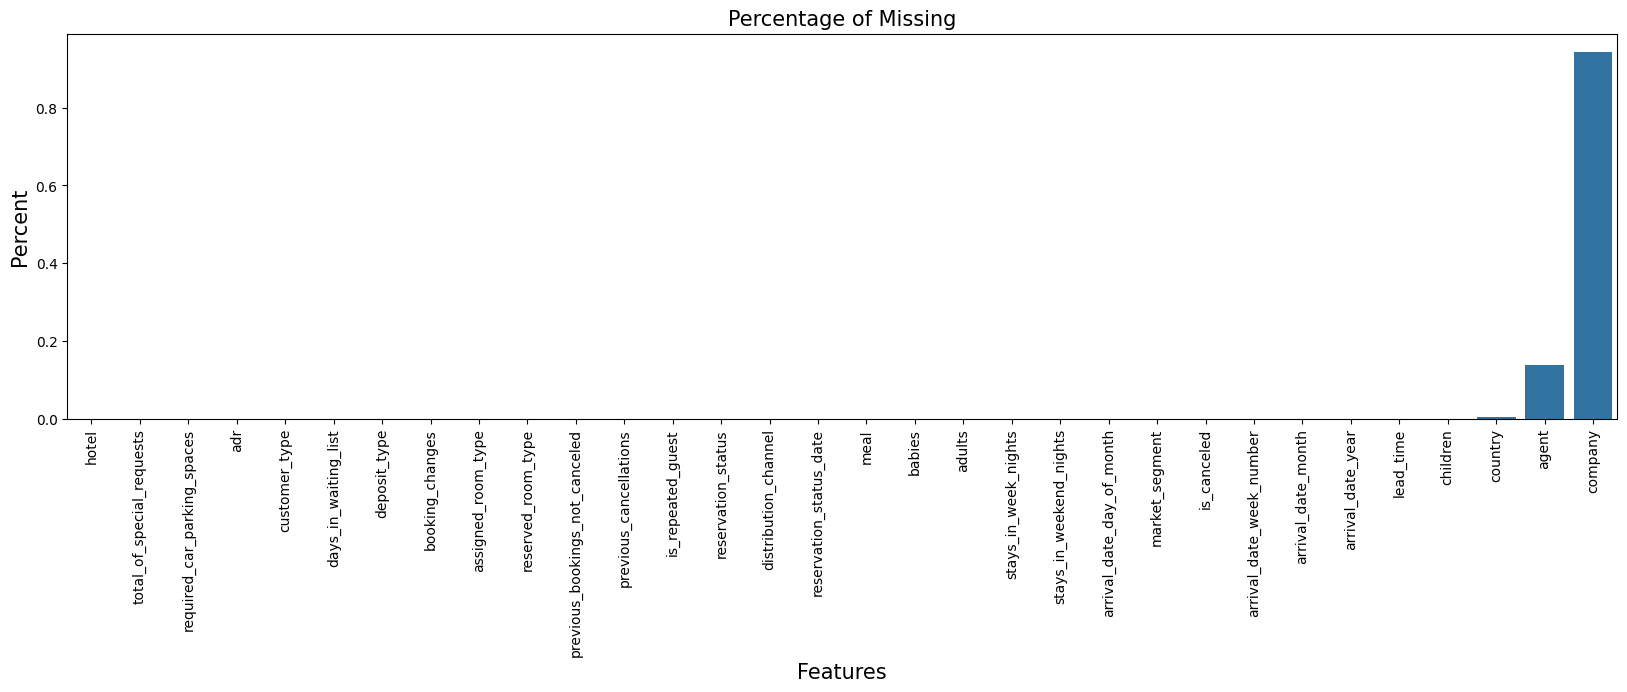

In [7]:
f, ax = plt.subplots(figsize=(20, 5))

sns.barplot(
    x='feature',
    y='percentageOfMissing',
    data=featuresStat.sort_values(by='percentageOfMissing')
)
plt.title('Percentage of Missing', fontsize=15)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent', fontsize=15)
plt.xticks(rotation=90)
plt.show()


In [8]:
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)


In [9]:
df = df.dropna(subset=['children'], axis=0)
df = df.reset_index(drop=True)

df['country'] = df['country'].fillna('Unknown')

featuresStat = df.isna().sum().rename('numOfMissing').reset_index()
featuresStat.columns = ['feature', 'numOfMissing']
featuresStat['percentageOfMissing'] = featuresStat['numOfMissing'].apply(lambda x: x / len(df))
featuresStat.sort_values(by='percentageOfMissing', ascending=False)


,feature,numOfMissing,percentageOfMissing
0,hotel,0,0.0
1,is_canceled,0,0.0
30,reservation_status,0,0.0
29,total_of_special_requests,0,0.0
28,required_car_parking_spaces,0,0.0
27,adr,0,0.0
26,customer_type,0,0.0
25,days_in_waiting_list,0,0.0
24,company,0,0.0
23,agent,0,0.0


In [10]:
cols = ["children", "agent", "company"]
df[cols] = df[cols].applymap(np.int64)


In [11]:
mealInterpretation = {
    'BB': "Breakfast",
    'FB': "Full Board",
    'HB': "Half Board",
    'SC': "No meal",
    'Undefined': "No meal"
}

df["meal"] = df["meal"].replace(mealInterpretation)
df["meal"].unique()

df["meal"] = pd.Categorical(df["meal"])


In [12]:
data = df.copy()


In [13]:
datetimeObject = data['arrival_date_month'].str[0:3]
monthNumber = np.zeros(len(datetimeObject))

for i in range(len(datetimeObject)):
    datetimeObject[i] = datetime.datetime.strptime(datetimeObject[i], "%b")
    monthNumber[i] = datetimeObject[i].month

monthNumber = pd.DataFrame(monthNumber).astype(int)

data['arrivalDate'] = (
    data['arrival_date_year'].map(str) + '-' +
    monthNumber[0].map(str) + '-' +
    data['arrival_date_day_of_month'].map(str)
)

data = data.drop(
    ['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date_week_number'],
    axis=1
)

data.head()


,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrivalDate
0,Resort Hotel,0,342,0,0,2,0,0,Breakfast,PRT,...,0,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
1,Resort Hotel,0,737,0,0,2,0,0,Breakfast,PRT,...,0,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
2,Resort Hotel,0,7,0,1,1,0,0,Breakfast,GBR,...,0,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
3,Resort Hotel,0,13,0,1,1,0,0,Breakfast,GBR,...,304,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
4,Resort Hotel,0,14,0,2,2,0,0,Breakfast,GBR,...,240,0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-7-1


In [14]:
data['arrivalDate'] = pd.to_datetime(data['arrivalDate'])
data['reservationStatusDate'] = pd.to_datetime(data['reservation_status_date'])

print('Datatype of the arrivalDate:', data['arrivalDate'].dtype)
print('Datatype of the reservationStatusDate:', data['reservationStatusDate'].dtype)


Datatype of the arrivalDate: datetime64[ns]
Datatype of the reservationStatusDate: datetime64[ns]


In [15]:
data['totalGuests'] = data['adults'] + data['children']
data = data[data['totalGuests'] != 0]

data['totalStays'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']

dataNoCancel = data[data['is_canceled'] == 0].reset_index(drop=True)

numberOfGuests = dataNoCancel[['arrivalDate', 'totalGuests']]

numberOfGuests


,arrivalDate,totalGuests
0,2015-07-01,2
1,2015-07-01,2
2,2015-07-01,1
3,2015-07-01,1
4,2015-07-01,2
...,...,...
75006,2017-08-30,2
75007,2017-08-31,3
75008,2017-08-31,2
75009,2017-08-31,2


In [16]:
numberOfGuests = dataNoCancel[['arrivalDate', 'totalGuests']]
numberOfGuestsDaily = dataNoCancel['totalGuests'].groupby(dataNoCancel['arrivalDate']).sum()
numberOfGuestsDaily = numberOfGuestsDaily.resample('d').sum().to_frame()
numberOfGuestsDaily


,totalGuests
arrivalDate,
2015-07-01,188
2015-07-02,73
2015-07-03,77
2015-07-04,94
2015-07-05,80
...,...
2017-08-27,265
2017-08-28,247
2017-08-29,150


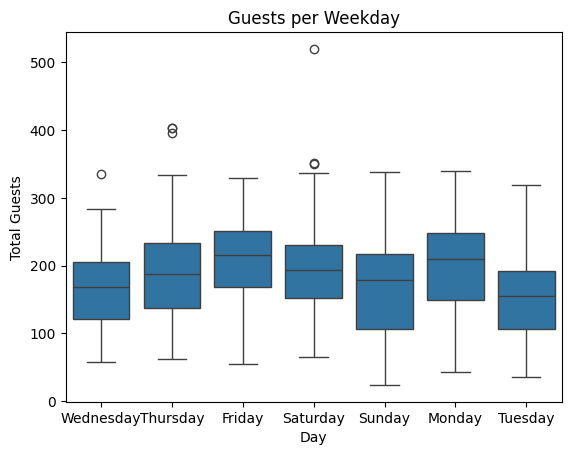

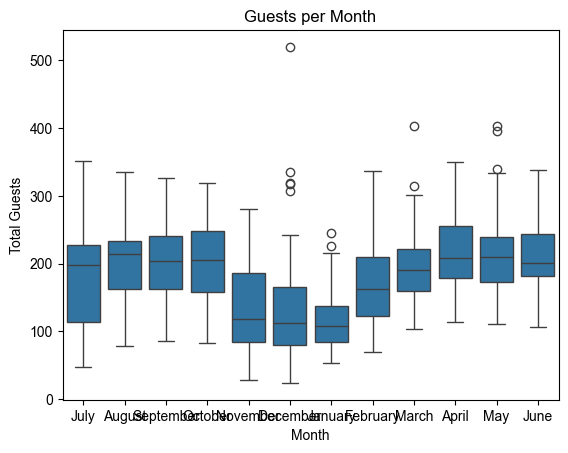

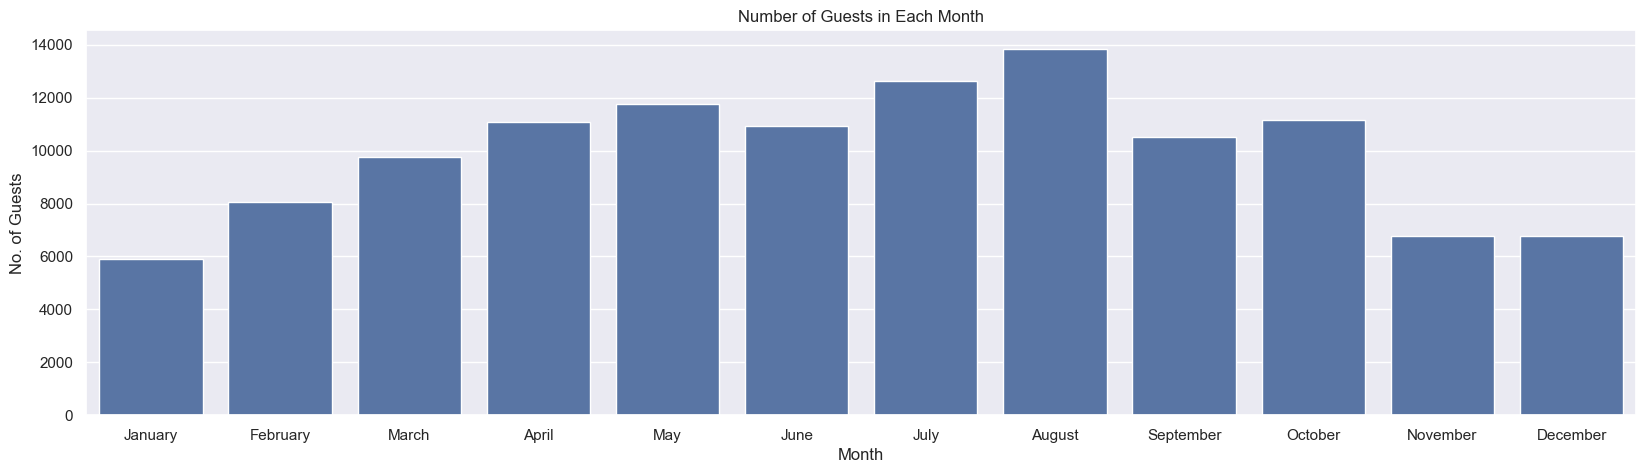

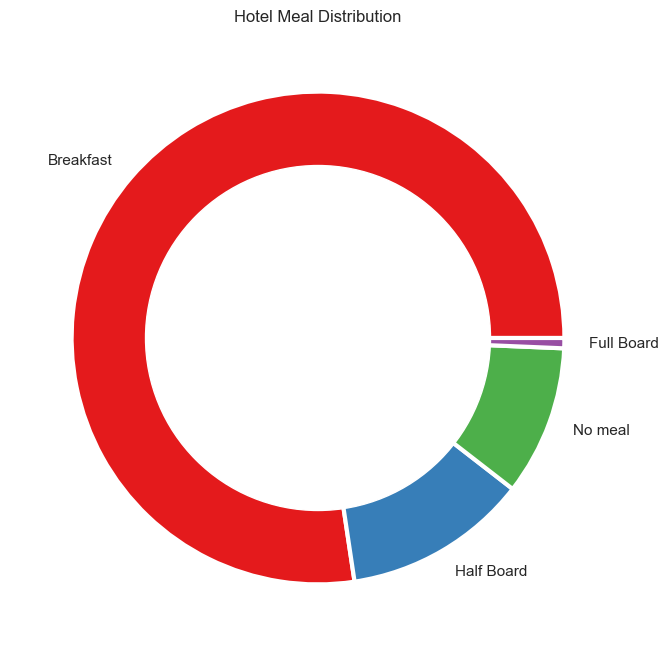

In [17]:
# Days-of-week distribution (boxplot)
dayNames = [idx.day_name() for idx in numberOfGuestsDaily.index]
daysDf = pd.DataFrame(dayNames, columns=['day'])

numberOfGuestsDailyBox = numberOfGuestsDaily.copy().reset_index(drop=True)
numberOfGuestsDailyBox = numberOfGuestsDailyBox.join(daysDf)

plt.title("Guests per Weekday")
sns.boxplot(x="day", y="totalGuests", data=numberOfGuestsDailyBox)
plt.xlabel("Day")
plt.ylabel("Total Guests")
plt.show()

# Month distribution (boxplot)
monthNames = [idx.month_name() for idx in numberOfGuestsDaily.index]
monthsDf = pd.DataFrame(monthNames, columns=['month'])

numberOfGuestsMonthly = numberOfGuestsDaily.copy().reset_index(drop=True)
numberOfGuestsMonthly = numberOfGuestsMonthly.join(monthsDf)

plt.title("Guests per Month")
sns.set(rc={"figure.figsize": (20, 4)})
sns.boxplot(x="month", y="totalGuests", data=numberOfGuestsMonthly)
plt.xlabel("Month")
plt.ylabel("Total Guests")
plt.show()

# Count of guests per month (using 'data' with arrivalDate)
monthOrder = ["January","February","March","April","May","June",
              "July","August","September","October","November","December"]

plt.figure(figsize=(20, 5))
sns.countplot(
    x=data['arrivalDate'].dt.month_name(),
    order=monthOrder
).set_title('Number of Guests in Each Month')
plt.xlabel('Month')
plt.ylabel('No. of Guests')
plt.show()

# Meal distribution (donut chart)
def drawMealCircle(df):
    mainMeal = df['meal'].value_counts()
    cmap = plt.get_cmap("Set1")
    colors = cmap(np.arange(len(mainMeal)) * 1)
    myCircle = plt.Circle((0, 0), 0.7, color='white')
    plt.pie(
        mainMeal.values,
        labels=mainMeal.index.tolist(),
        colors=colors,
        wedgeprops={'linewidth': 3, 'edgecolor': 'white'}
    )
    p = plt.gcf()
    p.gca().add_artist(myCircle)

fig, ax = plt.subplots(1, figsize=(8, 8))
drawMealCircle(data)
plt.title("Hotel Meal Distribution")
plt.show()


In [18]:
numberOfGuestsDaily.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793 entries, 2015-07-01 to 2017-08-31
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   totalGuests  793 non-null    int64
dtypes: int64(1)
memory usage: 12.4 KB


In [19]:
numberOfGuestsDaily.describe()

,totalGuests
count,793.000000
mean,183.136192
std,68.981344
min,24.000000
25%,130.000000
50%,187.000000
75%,228.000000
max,520.000000


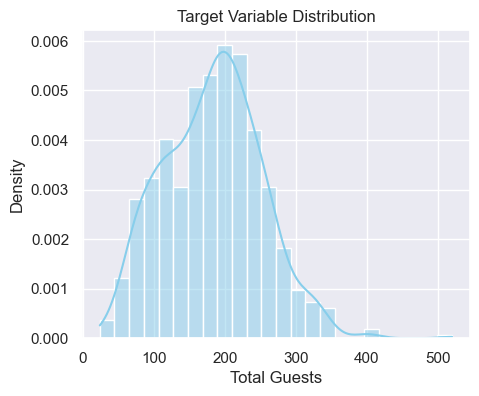

In [20]:
sns.set(rc={"figure.figsize": (5, 4)})
sns.histplot(numberOfGuestsDaily['totalGuests'], kde=True, stat='density', color='skyblue')
plt.title("Target Variable Distribution")
plt.xlabel("Total Guests")
plt.ylabel("Density")
plt.show()


In [21]:
fig = px.line(
    numberOfGuestsDaily.reset_index(),
    x='arrivalDate',
    y='totalGuests',
    title='Hotel Demand'
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='1y', step="year", stepmode="backward"),
            dict(count=2, label='2y', step="year", stepmode="backward"),
            dict(count=3, label='3y', step="year", stepmode="backward")
        ])
    )
)
fig.show()


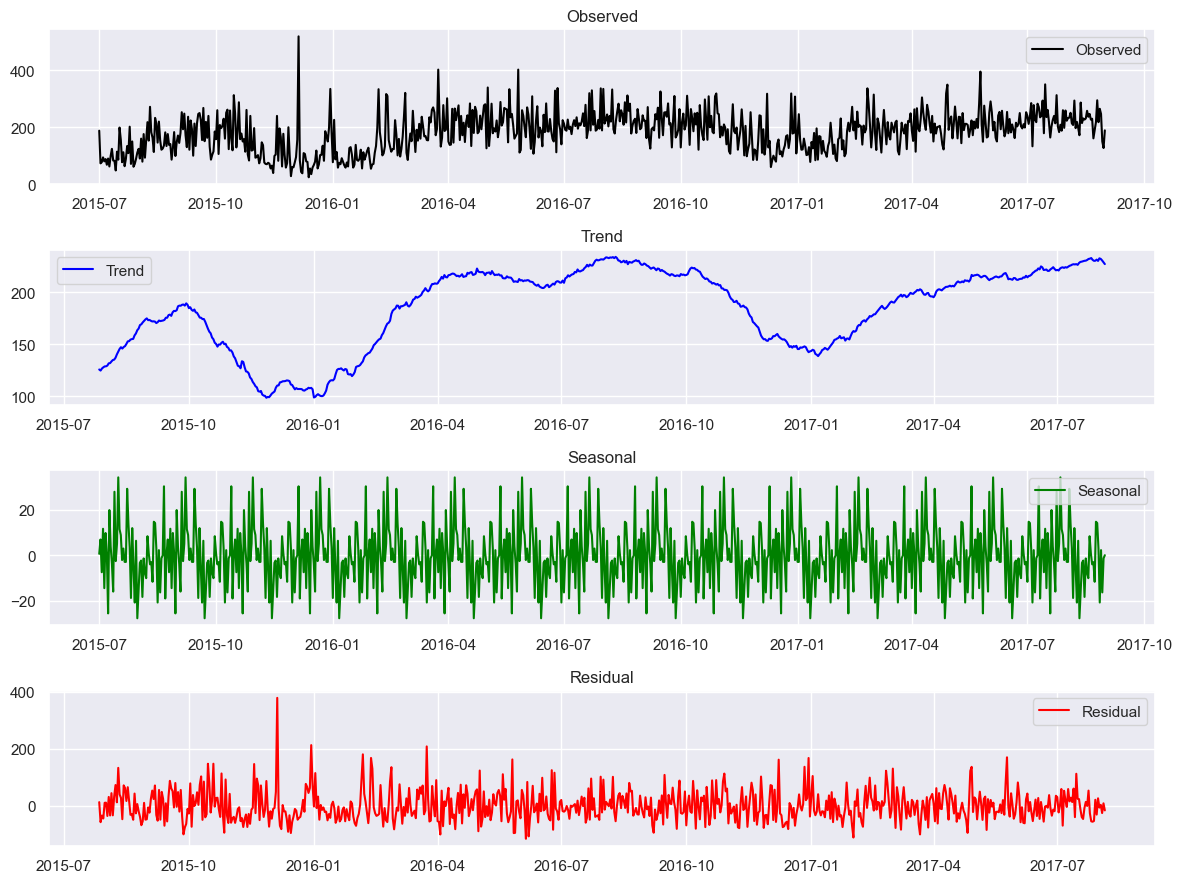

In [22]:
from matplotlib import gridspec

decomposition = sm.tsa.seasonal_decompose(
    numberOfGuestsDaily['totalGuests'],
    model='additive',
    period=53
)

fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1])

# Observed
ax1 = plt.subplot(gs[0])
ax1.plot(decomposition.observed, label='Observed', color='black')
ax1.set_title('Observed')
ax1.legend()

# Trend
ax2 = plt.subplot(gs[1])
ax2.plot(decomposition.trend, label='Trend', color='blue')
ax2.set_title('Trend')
ax2.legend()

# Seasonal
ax3 = plt.subplot(gs[2])
ax3.plot(decomposition.seasonal, label='Seasonal', color='green')
ax3.set_title('Seasonal')
ax3.legend()

# Residual
ax4 = plt.subplot(gs[3])
ax4.plot(decomposition.resid, label='Residual', color='red')
ax4.set_title('Residual')
ax4.legend()

plt.tight_layout()
plt.show()


In [23]:
from statsmodels.tsa.stattools import adfuller

def adfTest(timeSeries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeSeries, autolag='AIC')
    dfOutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfOutput[f'Critical Value ({key})'] = value
    print(dfOutput)


In [24]:
adfTest(numberOfGuestsDaily['totalGuests'])


Results of Dickey-Fuller Test:
Test Statistic                  -2.603322
p-value                          0.092313
#Lags Used                      20.000000
Number of Observations Used    772.000000
Critical Value (1%)             -3.438849
Critical Value (5%)             -2.865291
Critical Value (10%)            -2.568767
dtype: float64


In [25]:
from statsmodels.tsa.stattools import kpss

def kpssTest(timeSeries):
    print('Results of KPSS Test:')
    kpssTestResult = kpss(timeSeries, regression='c', nlags="auto")
    kpssOutput = pd.Series(kpssTestResult[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key, value in kpssTestResult[3].items():
        kpssOutput[f'Critical Value ({key})'] = value
    print(kpssOutput)



In [26]:
kpssTest(numberOfGuestsDaily['totalGuests'])


Results of KPSS Test:
Test Statistic            1.534473
p-value                   0.010000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [27]:
from statsmodels.tsa.stattools import adfuller, kpss

def obtainAdfKpssResults(timeSeries, maxD):
    """
    Build a DataFrame with ADF and KPSS p-values across successive differencing.

    Args:
        timeSeries (pd.Series): Univariate time series.
        maxD (int): Maximum number of differences to apply.

    Returns:
        pd.DataFrame: Columns:
            - d: number of differences applied
            - adfPValue
            - kpssPValue
            - isAdfStationary   (ADF p <= 0.05)
            - isKpssStationary  (KPSS p >  0.05)
            - isStationary      (both conditions met)
    """
    results = []
    ts = timeSeries.copy()

    for d in range(maxD):
        adfResult = adfuller(ts, autolag='AIC')
        kpssResult = kpss(ts, regression='c', nlags="auto")

        adfP = adfResult[1]
        kpssP = kpssResult[1]

        isAdfStationary = adfP <= 0.05
        isKpssStationary = kpssP > 0.05
        isStationary = isAdfStationary and isKpssStationary

        results.append((d, adfP, kpssP, isAdfStationary, isKpssStationary, isStationary))

        ts = ts.diff().dropna()

    resultsDf = pd.DataFrame(
        results,
        columns=['d', 'adfPValue', 'kpssPValue', 'isAdfStationary', 'isKpssStationary', 'isStationary']
    )
    return resultsDf


In [28]:
obtainAdfKpssResults(numberOfGuestsDaily['totalGuests'], 3)


,d,adfPValue,kpssPValue,isAdfStationary,isKpssStationary,isStationary
0,0,9.231258e-02,0.01,False,False,False
1,1,3.921010e-18,0.10,True,True,True
2,2,1.771988e-24,0.10,True,True,True


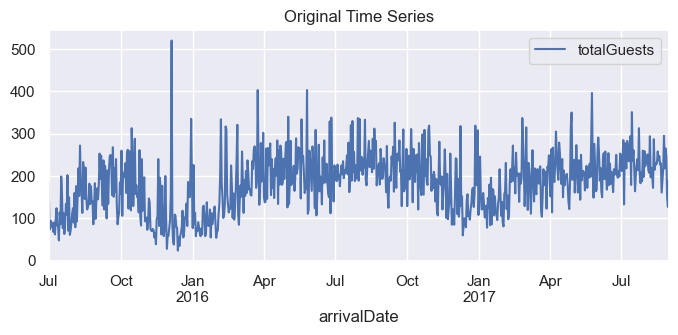

In [29]:
numberOfGuestsDaily.plot(grid=True, figsize=(8, 3), title="Original Time Series")
plt.show()


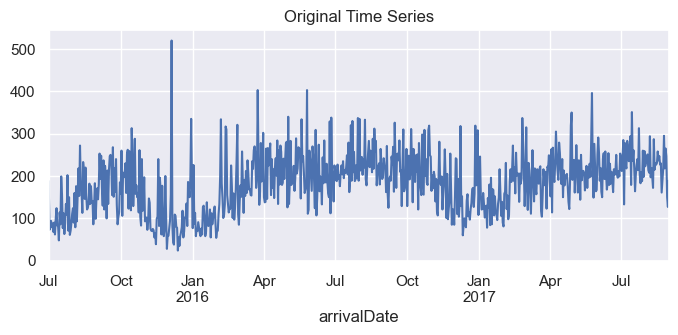

In [30]:
numberOfGuestsDaily['totalGuests'].plot(grid=True, figsize=(8, 3), title="Original Time Series")
plt.show()


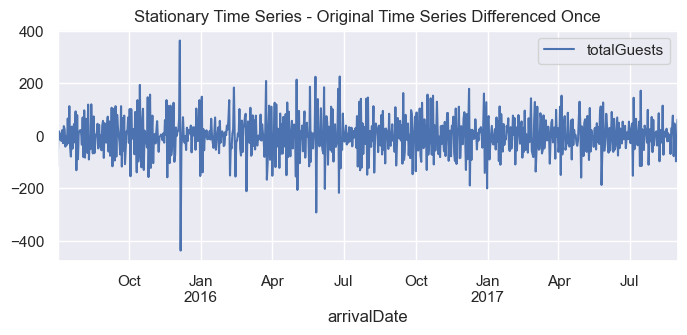

In [31]:
numberOfGuestsDaily.diff().dropna().plot(
    grid=True,
    figsize=(8, 3),
    title="Stationary Time Series - Original Time Series Differenced Once"
)
plt.show()


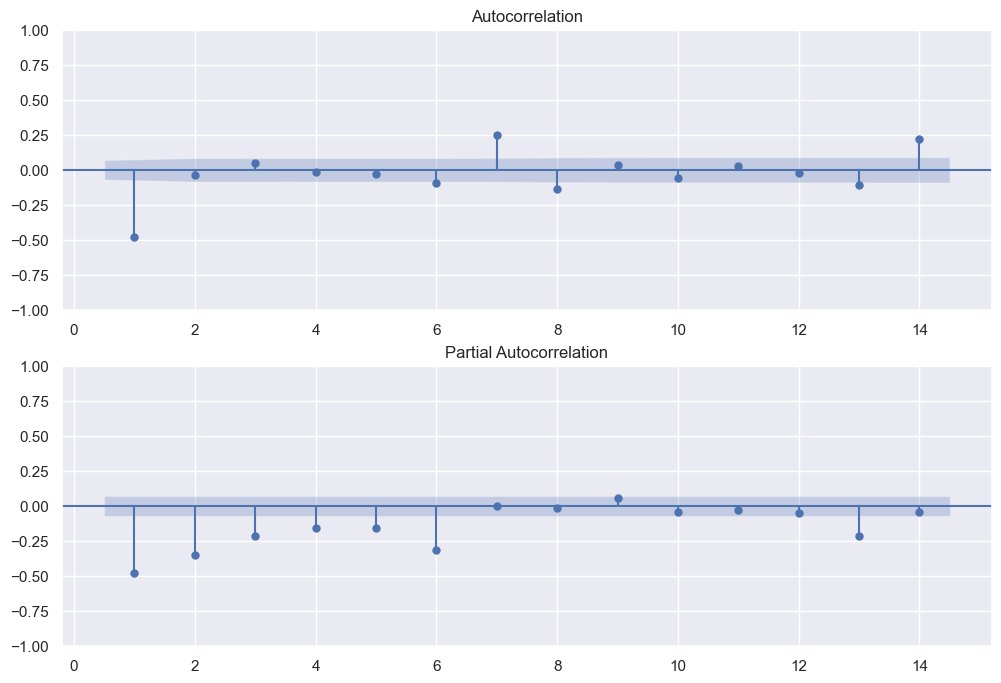

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(numberOfGuestsDaily.diff().dropna(), lags=14, zero=False, ax=ax1)
plot_pacf(numberOfGuestsDaily.diff().dropna(), lags=14, zero=False, ax=ax2)

plt.show()


In [33]:
numberOfGuestsDaily.index = pd.DatetimeIndex(
    numberOfGuestsDaily.index.values,
    freq=numberOfGuestsDaily.index.inferred_freq
)


In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Make sure the index has a fixed frequency
numberOfGuestsDaily.index = pd.DatetimeIndex(
    numberOfGuestsDaily.index.values,
    freq=numberOfGuestsDaily.index.inferred_freq
)

# Define and fit the SARIMAX model (without freq param)
model = SARIMAX(numberOfGuestsDaily, order=(1, 1, 1))
results = model.fit()

# Show model summary
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            totalGuests   No. Observations:                  793
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4325.726
Date:                Thu, 07 Aug 2025   AIC                           8657.452
Time:                        08:18:10   BIC                           8671.475
Sample:                    07-01-2015   HQIC                          8662.841
                         - 08-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0206      0.036      0.575      0.565      -0.049       0.091
ma.L1         -0.8958      0.017    -52.281      0.000      -0.929      -0.862
sigma2      3241.2257     98.933     32.762      0.000    3047.320    3435.132
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               649.56
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure DateTimeIndex has fixed frequency
numberOfGuestsDaily.index = pd.DatetimeIndex(numberOfGuestsDaily.index.values,
                                              freq=numberOfGuestsDaily.index.inferred_freq)

# Create empty list to store search results
order_aic_bic = []

# Loop over p and q values
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(numberOfGuestsDaily, order=(p, 1, q))
            results = model.fit(disp=False)
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            continue  # Skip invalid combinations

# Convert to DataFrame for better display
order_df = pd.DataFrame(order_aic_bic, columns=["p", "q", "AIC", "BIC"])

# Sort by AIC to find best combination
order_df.sort_values(by="AIC").reset_index(drop=True)


,p,q,AIC,BIC
0,6,6,8609.790247,8670.559545
1,5,6,8611.281165,8667.375902
2,6,5,8618.624359,8674.719095
3,3,6,8628.603046,8675.348660
4,6,0,8633.308066,8666.029995
5,6,3,8634.994009,8681.739623
6,6,1,8635.225016,8672.621507
7,2,3,8635.617227,8663.664596
8,6,4,8636.099239,8687.519414
9,6,2,8636.492600,8678.563653


In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

dfTrain = numberOfGuestsDaily[:701]
dfTest = numberOfGuestsDaily[701:]

arimaModel = SARIMAX(dfTrain, order=(6, 1, 6))
arimaResults = arimaModel.fit()

yHat = arimaResults.forecast(len(dfTest))

mae = mean_absolute_error(dfTest, yHat)
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(dfTest, yHat)
print('MAPE: %.3f' % mape)


MAE: 30.671
MAPE: 0.141


[Text(0, 0.5, 'Total Guests')]

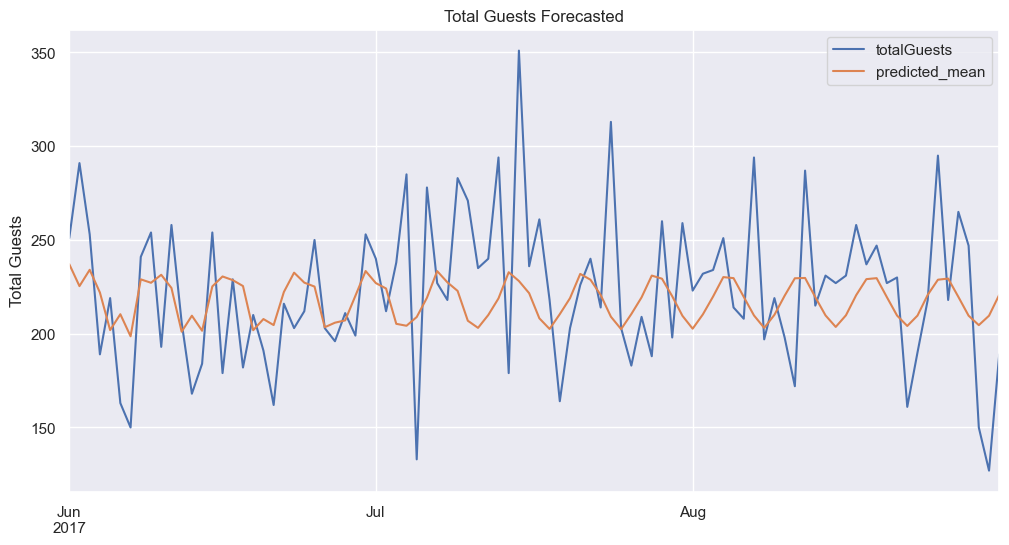

In [37]:
ax = dfTest['totalGuests'].plot(legend=True, figsize=(12, 6), title='Total Guests Forecasted')
yHat.plot(legend=True, ax=ax)
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='Total Guests')


In [38]:
arimaResults.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            totalGuests   No. Observations:                  701
Model:               SARIMAX(6, 1, 6)   Log Likelihood               -3815.848
Date:                Thu, 07 Aug 2025   AIC                           7657.697
Time:                        08:18:38   BIC                           7716.861
Sample:                    07-01-2015   HQIC                          7680.567
                         - 05-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9125      0.226     -4.031      0.000      -1.356      -0.469
ar.L2         -0.1940      0.107     -1.806      0.071      -0.405       0.017
ar.L3         -0.5099      0.060     -8.448      0.000      -0.628      -0.392
ar.L4         -1.1429      0.120     -9.494      0.000      -1.379      -0.907
ar.L5         -0.5187      0.213     -2.436      0.015      -0.936      -0.101
ar.L6         -0.1460      0.054     -2.722      0.006      -0.251      -0.041
ma.L1          0.0403      0.232      0.174      0.862      -0.414       0.494
ma.L2         -0.6696      0.115     -5.843      0.000      -0.894      -0.445
ma.L3          0.3479      0.136      2.552      0.011       0.081       0.615
ma.L4          0.7612      0.149      5.097      0.000       0.469       1.054
ma.L5         -0.4937      0.124     -3.980      0.000      -0.737      -0.251
ma.L6         -0.3746      0.195     -1.925      0.054      -0.756       0.007
sigma2      3302.4517    113.341     29.137      0.000    3080.307    3524.596
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               744.46
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.15
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
# Take the first difference and seasonal difference (seasonal_period=7), then drop NaNs
numberOfGuestsDailyDiff = numberOfGuestsDaily.diff().diff(7).dropna()


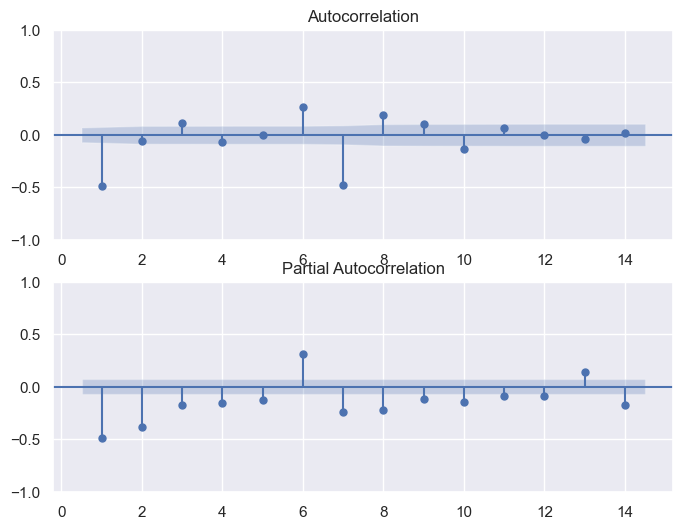

In [40]:
# Create the figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the ACF on ax1
plot_acf(numberOfGuestsDailyDiff, lags=14, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(numberOfGuestsDailyDiff, lags=14, zero=False, ax=ax2)

plt.show()


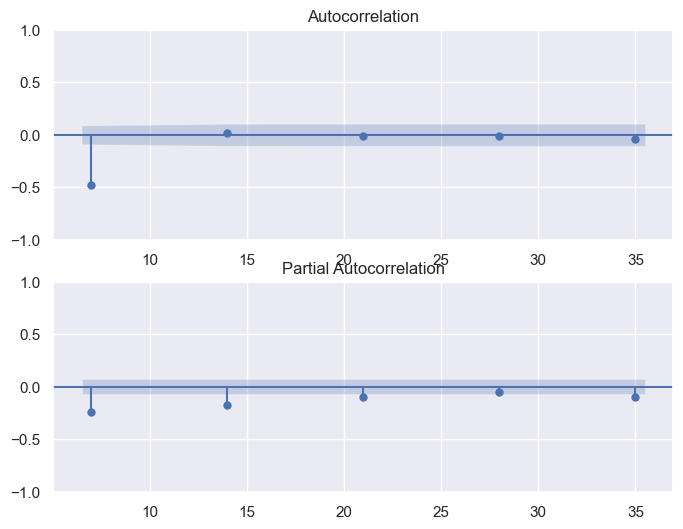

In [41]:
# Make list of lags
lags = [7, 14, 21, 28, 35]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the ACF on ax1
plot_acf(numberOfGuestsDailyDiff, lags=lags, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(numberOfGuestsDailyDiff, lags=lags, zero=False, ax=ax2)

plt.show()


In [42]:
sarima01Model = SARIMAX(dfTrain, order=(0, 1, 6), seasonal_order=(0, 1, 1, 7))

# Fit model
sarima01Results = sarima01Model.fit()
yHat = sarima01Results.forecast(len(dfTest))

# Calculate Mean Absolute Error
mae2 = mean_absolute_error(dfTest, yHat)
print('MAE: %.3f' % mae2)

# Calculate Mean Absolute Percentage Error
mape2 = mean_absolute_percentage_error(dfTest, yHat)
print('MAPE: %.3f' % mape2)


MAE: 29.701
MAPE: 0.141


[Text(0, 0.5, 'Total Guests')]

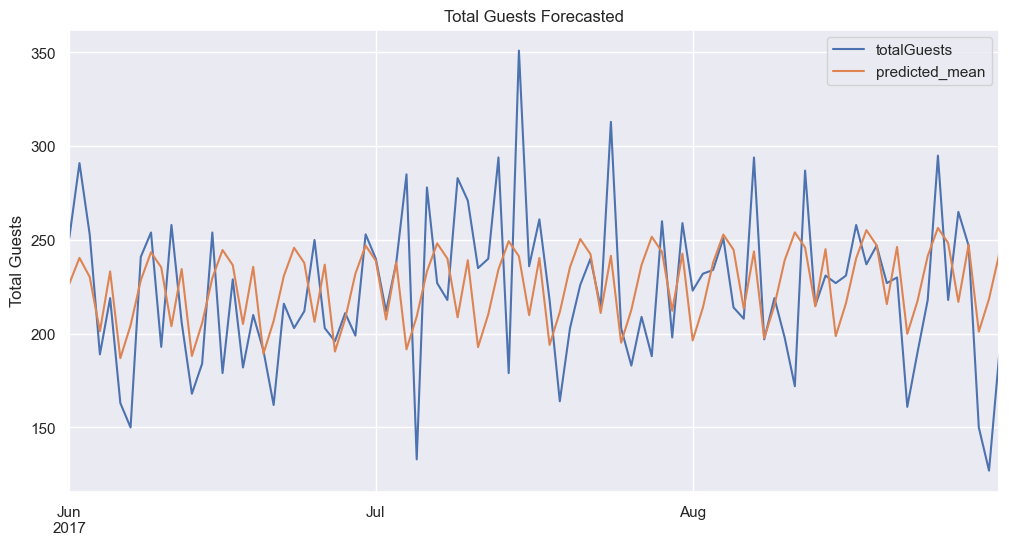

In [43]:
ax = dfTest['totalGuests'].plot(legend=True, figsize=(12, 6), title='Total Guests Forecasted')
yHat.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='Total Guests')


In [44]:
sarima01Results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         totalGuests   No. Observations:                  701
Model:             SARIMAX(0, 1, 6)x(0, 1, [1], 7)   Log Likelihood               -3778.356
Date:                             Thu, 07 Aug 2025   AIC                           7572.713
Time:                                     08:19:03   BIC                           7609.041
Sample:                                 07-01-2015   HQIC                          7586.762
                                      - 05-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8712      0.033    -26.141      0.000      -0.937      -0.806
ma.L2         -0.0208      0.041     -0.509      0.611      -0.101       0.059
ma.L3          0.0833      0.047      1.789      0.074      -0.008       0.175
ma.L4         -0.0424      0.054     -0.782      0.434      -0.149       0.064
ma.L5         -0.0321      0.056     -0.572      0.568      -0.142       0.078
ma.L6         -0.0026      0.044     -0.061      0.952      -0.088       0.083
ma.S.L7       -0.9985      0.117     -8.568      0.000      -1.227      -0.770
sigma2      3034.1566    350.627      8.654      0.000    2346.940    3721.373
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               708.07
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             1.07
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
import pmdarima as pm

# Create autoArima model
autoArimaModel = pm.auto_arima(
    numberOfGuestsDaily,      # time series
    seasonal=True,            # is the time series seasonal
    m=7,                      # the seasonal period - one week?
    d=1,                      # non-seasonal difference order
    D=1,                      # seasonal difference order
    max_p=6,                  # max value of p to test 
    max_q=6,                  # max value of q to test
    max_P=6,                  # max value of P to test 
    max_Q=6,                  # max value of Q to test 
    information_criterion='aic',    # used to select best model
    trace=True,               # prints the AIC for each model it fits
    error_action='ignore',    # ignore orders that don't work
    stepwise=True,            # apply an intelligent order search
    suppress_warnings=True    # suppress warnings
)

# Print model summary
print(autoArimaModel.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=inf, Time=2.10 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=9340.292, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=8917.648, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=9128.785, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=8852.460, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=8832.849, Time=1.60 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=8817.130, Time=1.26 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=8796.289, Time=1.32 sec
 ARIMA(1,1,0)(6,1,0)[7]             : AIC=8791.526, Time=1.82 sec
 ARIMA(1,1,0)(6,1,1)[7]             : AIC=inf, Time=7.52 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=inf, Time=4.84 sec
 ARIMA(0,1,0)(6,1,0)[7]             : AIC=9013.418, Time=1.78 sec
 ARIMA(2,1,0)(6,1,0)[7]             : AIC=8686.461, Time=2.05 sec
 ARIMA(2,1,0)(5,1,0)[7]             : AIC=8692.215, T

In [46]:
sarima02Model = SARIMAX(dfTrain, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7))
sarima02Results = sarima02Model.fit()

yhat = sarima02Results.forecast(len(dfTest))

# Calculate the mean absolute error from test data
mae3 = mean_absolute_error(dfTest, yhat)
print('MAE: %.3f' % mae3)

mape3 = mean_absolute_percentage_error(dfTest, yhat)
print('MAPE: %.3f' % mape3)


MAE: 33.508
MAPE: 0.155


[Text(0, 0.5, 'Total Guests')]

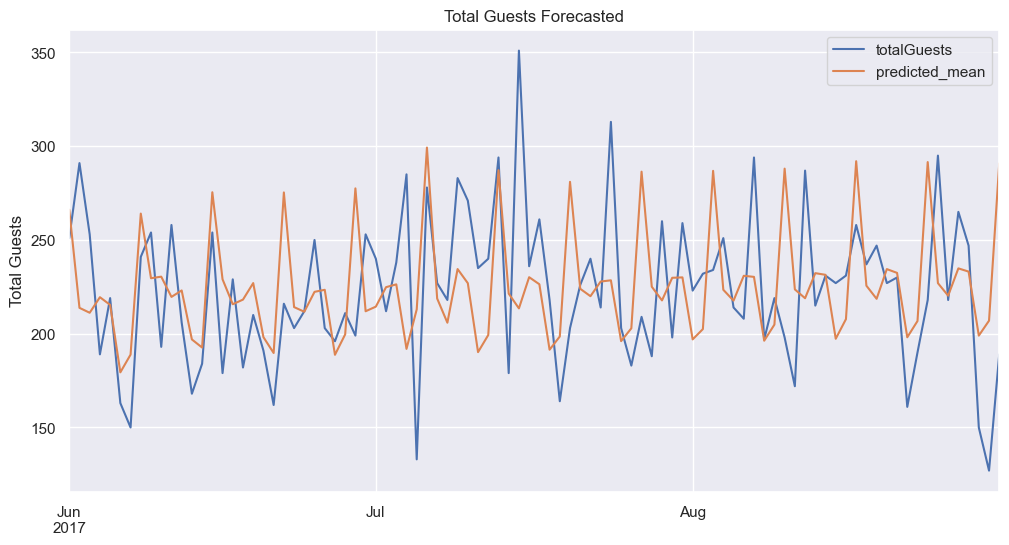

In [47]:
ax = dfTest['totalGuests'].plot(legend=True, figsize=(12, 6), title='Total Guests Forecasted')
yhat.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='Total Guests')


In [48]:
dfArimaResults = pd.DataFrame({
    'metrics': ['MAE', 'MAPE'],
    'ARIMA(6,1,6)': [round(mae, 3), round(mape, 4)],
    'SARIMA(0,1,6)(0,1,1)7': [round(mae2, 3), round(mape2, 4)],
    'SARIMA(6,1,0)(6,1,0)7': [round(mae3, 3), round(mape3, 4)]
})

dfArimaResults


,metrics,"ARIMA(6,1,6)","SARIMA(0,1,6)(0,1,1)7","SARIMA(6,1,0)(6,1,0)7"
0,MAE,30.6710,29.7010,33.5080
1,MAPE,0.1413,0.1411,0.1551


In [52]:
numberOfGuestsDaily=numberOfGuestsDaily.reset_index()

In [53]:
# rename date and sales, respectively ds and y
numberOfGuestsDaily.columns = ['ds','y']
numberOfGuestsDaily

,ds,y
0,2015-07-01,188
1,2015-07-02,73
2,2015-07-03,77
3,2015-07-04,94
4,2015-07-05,80
...,...,...
788,2017-08-27,265
789,2017-08-28,247
790,2017-08-29,150
791,2017-08-30,127


In [54]:
dfTrainProphet = numberOfGuestsDaily[:701]
dfTestProphet = numberOfGuestsDaily[701:]

In [55]:
Prophet01 = Prophet(interval_width=0.95)

In [57]:
model = Prophet01.fit(numberOfGuestsDaily)

08:25:41 - cmdstanpy - INFO - Chain [1] start processing
08:25:42 - cmdstanpy - INFO - Chain [1] done processing


In [58]:
# Method make_future_dataframe builds a dataframe that extends into the future a specified number of days. In our case, we will predict 91 days into the future.
future = Prophet01.make_future_dataframe(periods=91) 
future

,ds
0,2015-07-01
1,2015-07-02
2,2015-07-03
3,2015-07-04
4,2015-07-05
...,...
879,2017-11-26
880,2017-11-27
881,2017-11-28
882,2017-11-29


In [59]:
forecast = Prophet01.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01,108.383080,5.302710,205.255187,108.383080,108.383080,-3.239396,-3.239396,-3.239396,-17.343577,-17.343577,-17.343577,14.104181,14.104181,14.104181,0.0,0.0,0.0,105.143684
1,2015-07-02,108.674484,41.942934,234.347889,108.674484,108.674484,23.827771,23.827771,23.827771,8.912998,8.912998,8.912998,14.914774,14.914774,14.914774,0.0,0.0,0.0,132.502256
2,2015-07-03,108.965888,44.628486,244.094849,108.965888,108.965888,37.140192,37.140192,37.140192,21.616730,21.616730,21.616730,15.523462,15.523462,15.523462,0.0,0.0,0.0,146.106080
3,2015-07-04,109.257293,42.328014,233.632172,109.257293,109.257293,32.101082,32.101082,32.101082,16.178133,16.178133,16.178133,15.922949,15.922949,15.922949,0.0,0.0,0.0,141.358375
4,2015-07-05,109.548697,15.724745,212.967197,109.548697,109.548697,2.287503,2.287503,2.287503,-13.825696,-13.825696,-13.825696,16.113199,16.113199,16.113199,0.0,0.0,0.0,111.836200


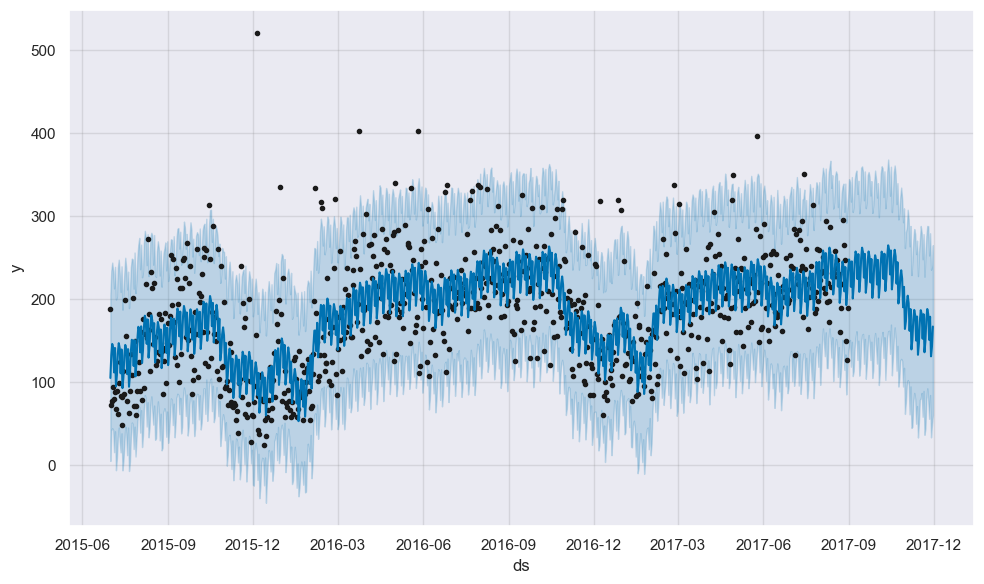

In [60]:
plot1 = Prophet01.plot(forecast)

In [62]:
dfMerge = pd.merge(numberOfGuestsDaily, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
dfMerge = dfMerge[['ds','yhat_lower','yhat_upper','yhat','y']]
dfMerge

,ds,yhat_lower,yhat_upper,yhat,y
0,2015-07-01,5.302710,205.255187,105.143684,188
1,2015-07-02,41.942934,234.347889,132.502256,73
2,2015-07-03,44.628486,244.094849,146.106080,77
3,2015-07-04,42.328014,233.632172,141.358375,94
4,2015-07-05,15.724745,212.967197,111.836200,80
...,...,...,...,...,...
788,2017-08-27,114.832243,305.170660,209.430402,265
789,2017-08-28,133.523549,339.192167,238.682379,247
790,2017-08-29,85.290823,292.076271,192.914539,150
791,2017-08-30,107.594932,307.827828,207.032854,127


In [63]:
# calculate MAE between observed and predicted values 
y_true = dfMerge['y'][701:].values
y_pred = dfMerge['yhat'][701:].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

MAE: 29.195
MAPE: 0.133


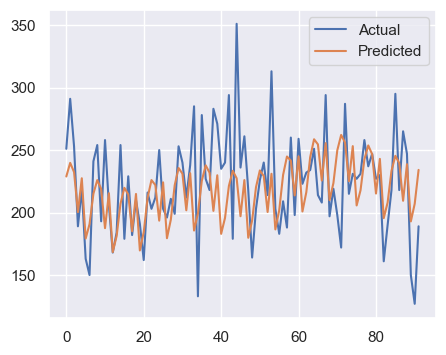

In [64]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [65]:
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

paramGrid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

allParams = [dict(zip(paramGrid.keys(), v)) for v in itertools.product(*paramGrid.values())]
maeList = []
mapeList = []

for params in allParams:
    model = Prophet(**params).fit(numberOfGuestsDaily)
    dfCv = cross_validation(model, horizon='90 days', parallel="processes")
    dfPerformance = performance_metrics(dfCv, rolling_window=1)
    maeList.append(dfPerformance['mae'].values[0])
    mapeList.append(dfPerformance['mape'].values[0])

tuningResults = pd.DataFrame(allParams)
tuningResults['mae'] = maeList
tuningResults['mape'] = mapeList


08:28:11 - cmdstanpy - INFO - Chain [1] start processing
08:28:11 - cmdstanpy - INFO - Chain [1] done processing
08:28:17 - cmdstanpy - INFO - Chain [1] start processing
08:28:17 - cmdstanpy - INFO - Chain [1] done processing
08:28:24 - cmdstanpy - INFO - Chain [1] start processing
08:28:24 - cmdstanpy - INFO - Chain [1] done processing
08:28:29 - cmdstanpy - INFO - Chain [1] start processing
08:28:29 - cmdstanpy - INFO - Chain [1] done processing
08:28:34 - cmdstanpy - INFO - Chain [1] start processing
08:28:34 - cmdstanpy - INFO - Chain [1] done processing
08:28:36 - cmdstanpy - INFO - Chain [1] start processing
08:28:36 - cmdstanpy - INFO - Chain [1] done processing
08:28:39 - cmdstanpy - INFO - Chain [1] start processing
08:28:39 - cmdstanpy - INFO - Chain [1] done processing
08:28:41 - cmdstanpy - INFO - Chain [1] start processing
08:28:41 - cmdstanpy - INFO - Chain [1] done processing
08:28:44 - cmdstanpy - INFO - Chain [1] start processing
08:28:44 - cmdstanpy - INFO - Chain [1]

In [66]:
tuningResultsDf = pd.DataFrame(tuningResults)


In [67]:
bestParams = allParams[np.argmin(mapeList)]
print(bestParams)


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


In [68]:
prophetModel = Prophet(
    interval_width=0.95,
    weekly_seasonality=True,
    changepoint_prior_scale=bestParams['changepoint_prior_scale'],
    seasonality_prior_scale=bestParams['seasonality_prior_scale']
)

fittedModel = prophetModel.fit(numberOfGuestsDaily)


08:31:57 - cmdstanpy - INFO - Chain [1] start processing
08:31:57 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
futureDataFrame = prophetModel.make_future_dataframe(periods=90)
forecastDataFrame = prophetModel.predict(futureDataFrame)


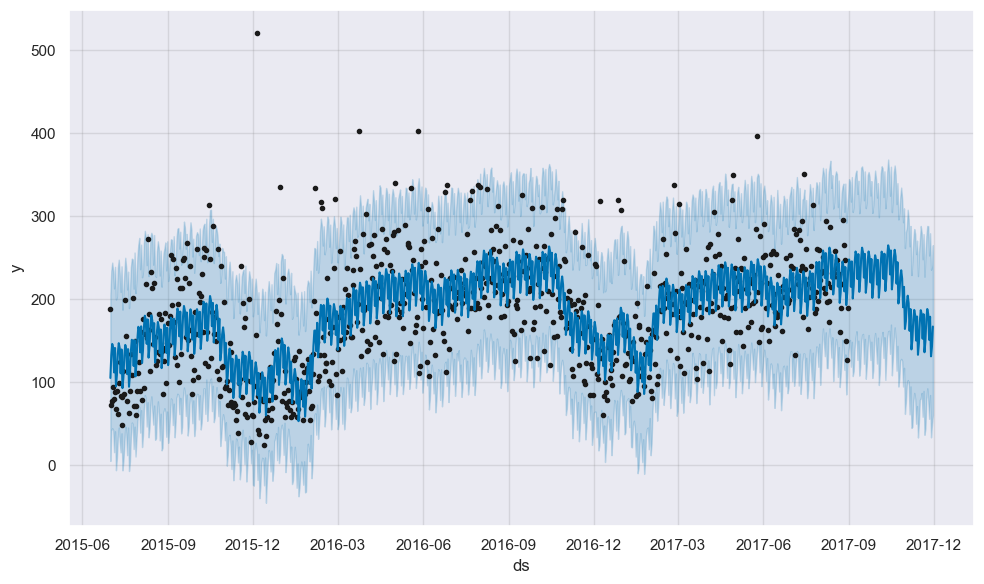

In [71]:
plot5 = prophetModel.plot(forecast)

In [72]:
dfMerge = pd.merge(numberOfGuestsDaily, forecastDataFrame[['ds', 'yhat_lower', 'yhat_upper', 'yhat']], on='ds')
dfMerge = dfMerge[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'y']]


In [73]:
# Calculate MAE and MAPE between expected and predicted values for December
yTrue = dfMerge['y'][701:].values
yPred = dfMerge['yhat'][701:].values

mae02 = mean_absolute_error(yTrue, yPred)
print('MAE: %.3f' % mae02)

mape02 = mean_absolute_percentage_error(yTrue, yPred)
print('MAPE: %.3f' % mape02)


MAE: 30.461
MAPE: 0.136


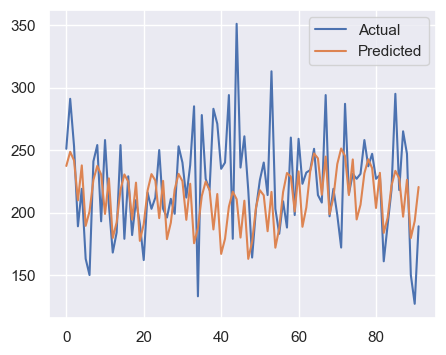

In [74]:
# Plot expected vs actual
plt.plot(yTrue, label='Actual')
plt.plot(yPred, label='Predicted')
plt.legend()
plt.show()


In [76]:
metricsProphet01 = [round(mae, 3), 
                    round(mape, 3)]

metricsProphet02 = [round(mae02, 3), 
                    round(mape02, 3)]


In [105]:
pd.DataFrame({
    'metrics': ['MAE', 'MAPE'],
    'prophet01': metricsProphet01,
    'prophet02': metricsProphet02,
})


,metrics,prophet01,prophet02
0,MAE,30.671,30.461
1,MAPE,0.141,0.136


In [78]:
prophetModel = Prophet(
    interval_width=0.95,
    weekly_seasonality=True,
    changepoint_prior_scale=bestParams['changepoint_prior_scale'],
    seasonality_prior_scale=bestParams['seasonality_prior_scale']
)

# The country is Portugal because many hotels in it
prophetModel.add_country_holidays(country_name='PT')

fittedModel = prophetModel.fit(numberOfGuestsDaily)


08:45:17 - cmdstanpy - INFO - Chain [1] start processing
08:45:17 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
# holidays included
prophetModel.train_holiday_names

0                                        New Year's Day
1                                           Good Friday
2                                         Easter Sunday
3                                        Corpus Christi
4                                          Republic Day
5                                       All Saints' Day
6                       Restoration of Independence Day
7                                           Freedom Day
8                                             Labor Day
9     Day of Portugal, Camões, and the Portuguese Co...
10                                       Assumption Day
11                                Immaculate Conception
12                                        Christmas Day
dtype: object

In [80]:
futureDataframe = prophetModel.make_future_dataframe(periods=90)  # To predict 90 days into the future
forecastResult = prophetModel.predict(futureDataframe)


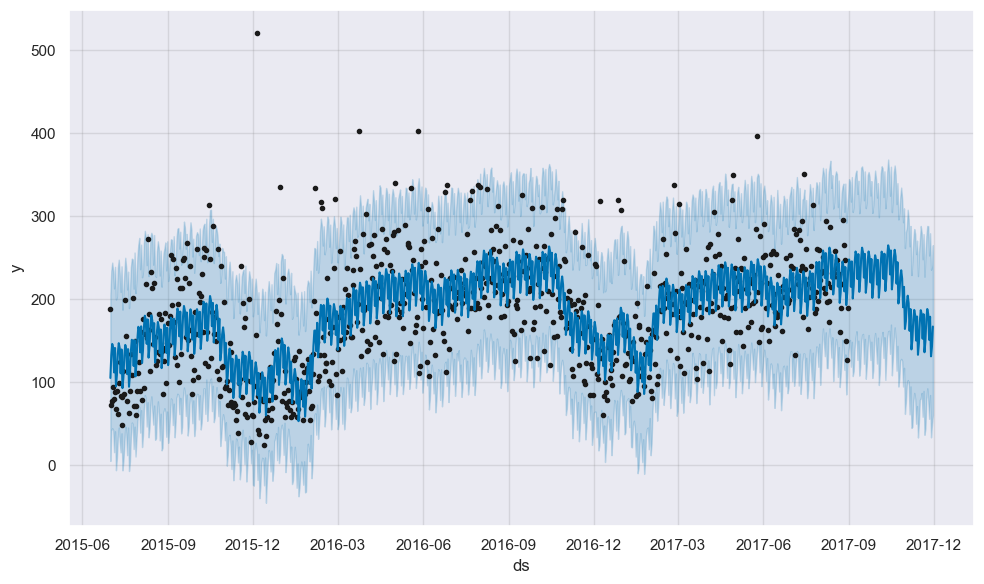

In [81]:
plot5 = prophetModel.plot(forecast)

In [82]:
mergedDataframe = pd.merge(numberOfGuestsDaily, forecastResult[['ds', 'yhat_lower', 'yhat_upper', 'yhat']], on='ds')
mergedDataframe = mergedDataframe[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'y']]


In [83]:
yTrue = mergedDataframe['y'][701:].values
yPred = mergedDataframe['yhat'][701:].values

mae03 = mean_absolute_error(yTrue, yPred)
print('MAE: %.3f' % mae03)

mape03 = mean_absolute_percentage_error(yTrue, yPred)
print('MAPE: %.3f' % mape03)


MAE: 30.624
MAPE: 0.135


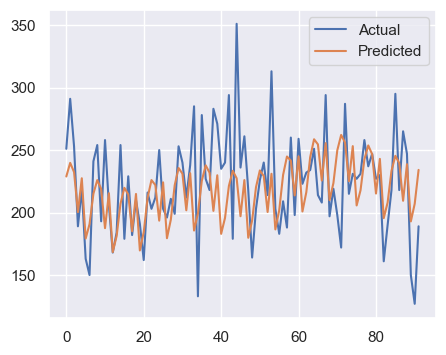

In [84]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [85]:
metricsProphet03 = [round(mae03, 3), round(mape03, 3)]


In [86]:
pd.DataFrame({
    'metrics': ['MAE', 'MAPE'],
    'prophet01': metricsProphet01,
    'prophet02': metricsProphet02,
    'prophet03': metricsProphet03
})


,metrics,prophet01,prophet02,prophet03
0,MAE,30.671,30.461,30.624
1,MAPE,0.141,0.136,0.135


In [88]:
# Prophet results
prophetResults = pd.DataFrame({
    'metrics': ['MAE', 'MAPE'],
    'prophet01': metricsProphet01, 
    'prophet02': metricsProphet02,
    'prophet03': metricsProphet03
})

# Merge with ARIMA results
combinedResults = dfArimaResults.merge(prophetResults, on='metrics')
combinedResults


,metrics,"ARIMA(6,1,6)","SARIMA(0,1,6)(0,1,1)7","SARIMA(6,1,0)(6,1,0)7",prophet01,prophet02,prophet03
0,MAE,30.6710,29.7010,33.5080,30.671,30.461,30.624
1,MAPE,0.1413,0.1411,0.1551,0.141,0.136,0.135


## RNN

In [113]:
dataTrain = numberOfGuestsDaily.copy()
dataTrain = dataTrain.reset_index(drop=True)
dataTrain.columns = ['Date', 'Total Guests']
dataTrain['Date'] = pd.to_datetime(dataTrain['Date'])
dataTrain.set_index('Date', inplace=True)
dataTrain.index.name = None  # Remove index name

dataTrain

,Total Guests
2015-07-01,188
2015-07-02,73
2015-07-03,77
2015-07-04,94
2015-07-05,80
...,...
2017-08-27,265
2017-08-28,247
2017-08-29,150
2017-08-30,127


In [143]:
def convertToMatrix(dataArr, lookBack):
    x, y = [], []
    for i in range(len(dataArr) - lookBack):
        d = i + lookBack  
        x.append(dataArr[i:d,])
        y.append(dataArr[d,])
    return np.array(x), np.array(y)


In [144]:
trainSize = 701
train, test = dataTrain.values[0:trainSize, :], dataTrain.values[trainSize:len(dataTrain.values), :]
lookBack = 7  # create window size as lookBack = 30
# test = np.append(test, np.repeat(test[-1,], lookBack))
# train = np.append(train, np.repeat(train[-1,], lookBack))
trainX, trainY = convertToMatrix(train, lookBack)
testX, testY = convertToMatrix(test, lookBack)
# reshape input to be [samples, window size, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [145]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping

def modelRnn(lookBack):
    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(1, lookBack), activation="relu"))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model


In [146]:
def modelLoss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.show()


In [147]:
modelRnnInstance = modelRnn(lookBack)

history = modelRnnInstance.fit(
    trainX, trainY,
    epochs=100,
    batch_size=30,
    verbose=1,
    validation_data=(testX, testY),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    shuffle=False
)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9689.7100 - mae: 77.9156 - mse: 9689.7100 - val_loss: 3440.5957 - val_mae: 47.2342 - val_mse: 3440.5957
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4494.9780 - mae: 49.7024 - mse: 4494.9780 - val_loss: 2116.7905 - val_mae: 35.5026 - val_mse: 2116.7905
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4011.0386 - mae: 47.8774 - mse: 4011.0386 - val_loss: 1975.0581 - val_mae: 34.5330 - val_mse: 1975.0581
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3796.3760 - mae: 46.0328 - mse: 3796.3760 - val_loss: 1882.5281 - val_mae: 33.7645 - val_mse: 1882.5281
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3676.5625 - mae: 45.1075 - mse: 3676.5625 - val_loss: 1821.7878 - val_mae: 33.3322 - val_mse: 1821.7878
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3571.7600 - mae: 44.3265 - mse: 3571.7600 - val_loss: 1752.1967 - val_mae: 32.8260 - val_mse: 1752.1967
Epoch 7/100
24/24 ━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Root Mean Squared Error (RMSE): 54.85; Train Mean Absolute Error (MAE): 40.99
Test Root Mean Squared Error (RMSE): 39.57; Test Mean Absolute Error (MAE): 30.67


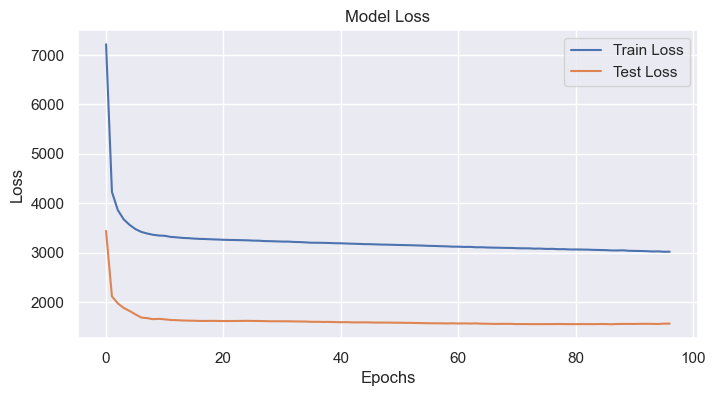

In [148]:
trainPredict = modelRnnInstance.predict(trainX)
testPredict = modelRnnInstance.predict(testX)

print('Train Root Mean Squared Error (RMSE): %.2f; Train Mean Absolute Error (MAE): %.2f' %
      (np.sqrt(mean_squared_error(trainY, trainPredict[:, 0])), mean_absolute_error(trainY, trainPredict[:, 0])))

rmse05, mae05 = np.sqrt(mean_squared_error(testY, testPredict[:, 0])), mean_absolute_error(testY, testPredict[:, 0])
print('Test Root Mean Squared Error (RMSE): %.2f; Test Mean Absolute Error (MAE): %.2f' %
      (rmse05, mae05))

modelLoss(history)


In [149]:
def predictionPlot(testY, testPredict):
    lenPrediction = [x for x in range(len(testY))]
    plt.figure(figsize=(8, 4))
    plt.plot(lenPrediction, testY[:], marker='.', label="actual")
    plt.plot(lenPrediction, testPredict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Ads Daily Spend', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()


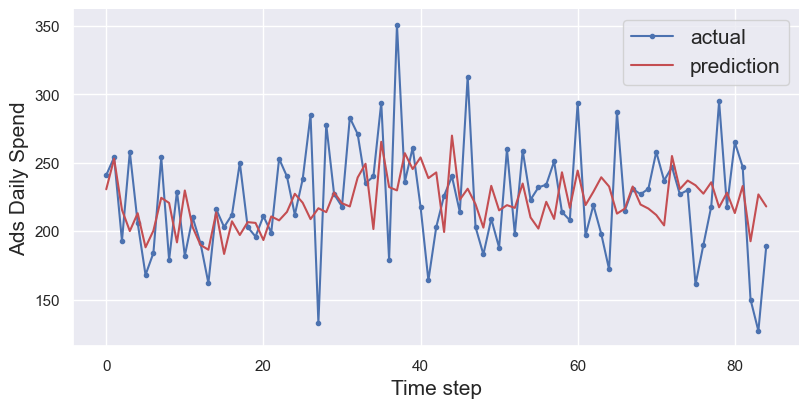

In [150]:
predictionPlot(testY, testPredict)


In [151]:
metricsRnn = [round(mae05, 3), round(rmse05, 3)]

pd.DataFrame({
    'metrics': ['RMSE', 'MAE'],
    'rnn': metricsRnn
})


,metrics,rnn
0,RMSE,30.665
1,MAE,39.567


## LSTM

In [152]:
def convertToMatrix(dataArr, lookBack):
    x, y = [], []
    for i in range(len(dataArr) - lookBack):
        d = i + lookBack  
        x.append(dataArr[i:d,])
        y.append(dataArr[d,])
    return np.array(x), np.array(y)


In [153]:
from sklearn.preprocessing import MinMaxScaler

# Create numpy.ndarray
dfArr = dataTrain.values  
dfArr = np.reshape(dfArr, (-1, 1))  # LSTM requires more input features compared to RNN or DNN

scaler = MinMaxScaler(feature_range=(0, 1))  # LSTM is sensitive to the scale of features
dfArr = scaler.fit_transform(dfArr)


In [154]:
trainSize = 701
n = trainSize
m = len(dfArr)
testSize = m - n

train, test = dfArr[0:trainSize, :], dfArr[trainSize:len(dfArr), :]
lookBack = 7

trainX, trainY = convertToMatrix(train, lookBack)
testX, testY = convertToMatrix(test, lookBack)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [155]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

def modelLstm(lookBack):
    model = Sequential()
    model.add(LSTM(100, input_shape=(1, lookBack), activation='relu'))
    model.add(Dense(4))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

modelLstmInstance = modelLstm(lookBack)

history = modelLstmInstance.fit(
    trainX, trainY,
    epochs=100,
    batch_size=30,
    validation_data=(testX, testY),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1,
    shuffle=False
)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0685 - mae: 0.2236 - mse: 0.0685 - val_loss: 0.0078 - val_mae: 0.0684 - val_mse: 0.0078
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mae: 0.1042 - mse: 0.0162 - val_loss: 0.0071 - val_mae: 0.0644 - val_mse: 0.0071
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - mae: 0.0993 - mse: 0.0154 - val_loss: 0.0071 - val_mae: 0.0643 - val_mse: 0.0071
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - mae: 0.0981 - mse: 0.0150 - val_loss: 0.0069 - val_mae: 0.0629 - val_mse: 0.0069
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0971 - mse: 0.0148 - val_loss: 0.0067 - val_mae: 0.0622 - val_mse: 0.0067
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - mae: 0.0960 - mse: 0.0146 - val_loss: 0.0066 - val_mae: 0.0618 - val_mse: 0.0066
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0948 - mse: 0.0143 - val_loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train Root Mean Squared Error (RMSE): 53.70; Train Mean Absolute Error (MAE): 41.07
Test Root Mean Squared Error (RMSE): 39.56; Test Mean Absolute Error (MAE): 30.20


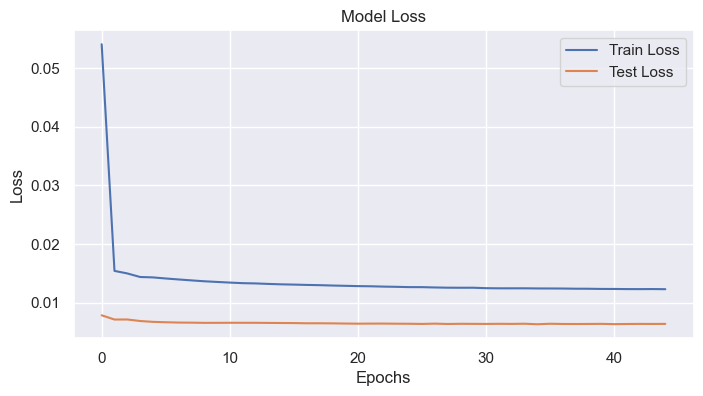

In [156]:
from sklearn.metrics import mean_absolute_error 

trainPredict = modelLstmInstance.predict(trainX)
testPredict = modelLstmInstance.predict(testX)

trainPredicted = scaler.inverse_transform(trainPredict)
trainTrue = scaler.inverse_transform(trainY)
testPredicted = scaler.inverse_transform(testPredict)
testTrue = scaler.inverse_transform(testY)

print('Train Root Mean Squared Error (RMSE): %.2f; Train Mean Absolute Error (MAE): %.2f' %
      (np.sqrt(mean_squared_error(trainTrue, trainPredicted[:, 0])), mean_absolute_error(trainTrue, trainPredicted[:, 0])))

rmse06, mae06 = np.sqrt(mean_squared_error(testTrue, testPredicted[:, 0])), mean_absolute_error(testTrue, testPredicted[:, 0])

print('Test Root Mean Squared Error (RMSE): %.2f; Test Mean Absolute Error (MAE): %.2f' %
      (rmse06, mae06))

modelLoss(history)


In [157]:
def predictionPlott(testTrue, testPredicted):
    lenPrediction = [x for x in range(len(testTrue))]
    plt.plot(lenPrediction, testTrue[:], marker='.', label="actual")
    plt.plot(lenPrediction, testPredicted[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Guest Daily', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()


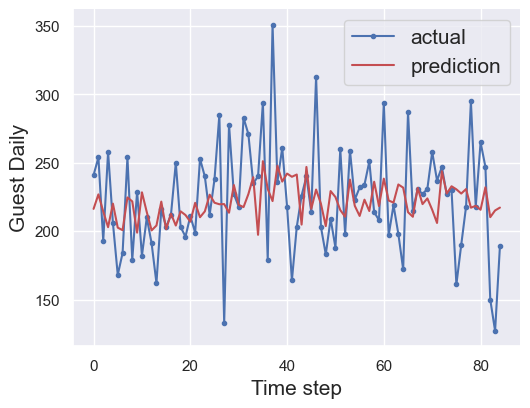

In [158]:
predictionPlott(testTrue, testPredicted)


In [159]:
metricsLstm = [round(mae06, 3), round(rmse06, 3)]

pd.DataFrame({
    'metrics': ['RMSE', 'MAE'],
    'lstm': metricsLstm
})


,metrics,lstm
0,RMSE,30.197
1,MAE,39.559


In [163]:
# LSTM results
nnResults = pd.DataFrame({
    'metrics': ['RMSE', 'MAE'],
    'rnn': metricsRnn,
    'lstm': metricsLstm
})

# Merge by arimaResults
dfResult = dfArimaResults.merge(prophetResults, on='metrics')

# Merge by prophetResults
dfResult = dfResult.merge(nnResults, on='metrics')
dfResult



,metrics,"ARIMA(6,1,6)","SARIMA(0,1,6)(0,1,1)7","SARIMA(6,1,0)(6,1,0)7",prophet01,prophet02,prophet03,rnn,lstm
0,MAE,30.671,29.701,33.508,30.671,30.461,30.624,39.567,39.559
